# Berater Environment v13

## Changes from v12 (work in progress)
* migration to easyagents

### Install gym

In [3]:
!pip install gym==0.10.11 > /dev/null

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


# Define Gym Environment

### Imports

In [4]:
import numpy as np
import random

import gym
from gym.utils import seeding
from gym import spaces

import pdb

### Helper methods

In [5]:
def state_name_to_int(state):
    state_name_map = {
        'S': 0,
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
        'H': 8,
        'K': 9,
        'L': 10,
        'M': 11,
        'N': 12,
        'O': 13
    }
    return state_name_map[state]

def int_to_state_name(state_as_int):
    state_map = {
        0: 'S',
        1: 'A',
        2: 'B',
        3: 'C',
        4: 'D',
        5: 'E',
        6: 'F',
        7: 'G',
        8: 'H',
        9: 'K',
        10: 'L',
        11: 'M',
        12: 'N',
        13: 'O'
    }
    return state_map[state_as_int]
    


### Berater Environment (OpenAI Gym)

In [6]:
class BeraterEnv(gym.Env):
    """
    The Berater Problem

    Actions: 
    There are 4 discrete deterministic actions, each choosing one direction
    """
    metadata = {'render.modes': ['ansi']}
    
    showStep = False
    showDone = True
    envEpisodeModulo = 100

    def __init__(self):
#         self.map = {
#             'S': [('A', 100), ('B', 400), ('C', 200 )],
#             'A': [('B', 250), ('C', 400), ('S', 100 )],
#             'B': [('A', 250), ('C', 250), ('S', 400 )],
#             'C': [('A', 400), ('B', 250), ('S', 200 )]
#         }
        self.map = {
            'S': [('A', 300), ('B', 100), ('C', 200 )],
            'A': [('S', 300), ('B', 100), ('E', 100 ), ('D', 100 )],
            'B': [('S', 100), ('A', 100), ('C', 50 ), ('K', 200 )],
            'C': [('S', 200), ('B', 50), ('M', 100 ), ('L', 200 )],
            'D': [('A', 100), ('F', 50)],
            'E': [('A', 100), ('F', 100), ('H', 100)],
            'F': [('D', 50), ('E', 100), ('G', 200)],
            'G': [('F', 200), ('O', 300)],
            'H': [('E', 100), ('K', 300)],
            'K': [('B', 200), ('H', 300)],
            'L': [('C', 200), ('M', 50)],
            'M': [('C', 100), ('L', 50), ('N', 100)],
            'N': [('M', 100), ('O', 100)],
            'O': [('N', 100), ('G', 300)]
        }
        max_paths = 4
        self.action_space = spaces.Discrete(max_paths)
      
        positions = len(self.map)
        # observations: position, reward of all 4 local paths, rest reward of all locations
        # non existing path is -1000 and no position change
        # look at what #getObservation returns if you are confused
        low = np.append(np.append([0], np.full(max_paths, -1000)), np.full(positions, 0))
        high = np.append(np.append([positions - 1], np.full(max_paths, 1000)), np.full(positions, 1000))
        self.observation_space = spaces.Box(low=low,
                                             high=high,
                                             dtype=np.float32)
        self.reward_range = (-1, 1)

        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False

        self.envReward = 0
        self.envEpisodeCount = 0
        self.envStepCount = 0

        self.reset()
        self.optimum = self.calculate_customers_reward()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def iterate_path(self, state, action):
        paths = self.map[state]
        if action < len(paths):
          return paths[action]
        else:
          # sorry, no such action, stay where you are and pay a high penalty
          return (state, 1000)
      
    def step(self, action):
        if self.debugStep:
          pdb.set_trace()
        destination, cost = self.iterate_path(self.state, action)
        lastState = self.state
        customerReward = self.customer_reward[destination]
        reward = (customerReward - cost) / self.optimum

        self.state = destination
        self.customer_visited(destination)
        done = (destination == 'S' and self.all_customers_visited())
        if self.stepCount >= 200:
          if BeraterEnv.showDone:
            print("Done: stepCount >= 200")
          done = True

        stateAsInt = state_name_to_int(self.state)
        self.totalReward += reward
        self.stepCount += 1
        self.envReward += reward
        self.envStepCount += 1

        if self.showStep:
            print( "Episode: " + ("%4.0f  " % self.envEpisodeCount) + 
                   " Step: " + ("%4.0f  " % self.stepCount) + 
                   lastState + ' --' + str(action) + '-> ' + self.state + 
                   ' R=' + ("% 2.2f" % reward) + ' totalR=' + ("% 3.2f" % self.totalReward) + 
                   ' cost=' + ("%4.0f" % cost) + ' customerR=' + ("%4.0f" % customerReward) + ' optimum=' + ("%4.0f" % self.optimum)      
                   )

        if done and not self.isDone:
            self.envEpisodeCount += 1
            if BeraterEnv.showDone:
                episodes = BeraterEnv.envEpisodeModulo
                if (self.envEpisodeCount % BeraterEnv.envEpisodeModulo != 0):
                    episodes = self.envEpisodeCount % BeraterEnv.envEpisodeModulo
                print( "Done: " + 
                        ("episodes=%6.0f  " % self.envEpisodeCount) + 
                        ("avgSteps=%6.2f  " % (self.envStepCount/episodes)) + 
                        ("avgTotalReward=% 3.2f" % (self.envReward/episodes) )
                        )
                if (self.envEpisodeCount%BeraterEnv.envEpisodeModulo) == 0:
                    self.envReward = 0
                    self.envStepCount = 0

        self.isDone = done
        observation = self.getObservation(stateAsInt)
        info = {"from": self.state, "to": destination}

        return observation, reward, done, info

    def getObservation(self, position):
        result = np.array([ position, 
                               self.getPathObservation(position, 0),
                               self.getPathObservation(position, 1),
                               self.getPathObservation(position, 2),
                               self.getPathObservation(position, 3)
                              ],
                             dtype=np.float32)
        all_rest_rewards = list(self.customer_reward.values())
        result = np.append(result, all_rest_rewards)
        return result

    def getPathObservation(self, position, path):
        source = int_to_state_name(position)
        paths = self.map[self.state]
        if path < len(paths):
          target, cost = paths[path]
          reward = self.customer_reward[target] 
          result = reward - cost
        else:
          result = -1000

        return result

    def customer_visited(self, customer):
        self.customer_reward[customer] = 0

    def all_customers_visited(self):
        return self.calculate_customers_reward() == 0

    def calculate_customers_reward(self):
        sum = 0
        for value in self.customer_reward.values():
            sum += value
        return sum

      
    def modulate_reward(self):
      number_of_customers = len(self.map) - 1
      number_per_consultant = int(number_of_customers/2)
#       number_per_consultant = int(number_of_customers/1.5)
      self.customer_reward = {
          'S': 0
      }
      for customer_nr in range(1, number_of_customers + 1):
        self.customer_reward[int_to_state_name(customer_nr)] = 0
      
      # every consultant only visits a few random customers
      samples = random.sample(range(1, number_of_customers + 1), k=number_per_consultant)
      key_list = list(self.customer_reward.keys())
      for sample in samples:
        self.customer_reward[key_list[sample]] = 1000

      
    def reset(self):
        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False

        self.modulate_reward()
        self.state = 'S'
        return self.getObservation(state_name_to_int(self.state))
      
    def render(self):
      print(self.customer_reward)

In [7]:
BeraterEnv.showStep = False
BeraterEnv.showDone = False
BeraterEnv.debugStep = False

### Register with OpenAI Gym

In [8]:
if not 'isEnvRegistered' in locals():
  env_name="Berater-v1"
  gym.envs.registration.register(id=env_name,entry_point=BeraterEnv,max_episode_steps=1000)
  isEnvRegistered=True
  print("Berater registered as '" + env_name + "'")
else:
  print("Already registered")

Berater registered as 'Berater-v1'


# Train policy with tfagents PpoAgent

## Install

In [17]:
!pip install -i https://test.pypi.org/simple/ easyagents > /dev/null

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [28]:
from easyagents.tfagents import PpoAgent
from easyagents.config import TrainingDuration
from easyagents.config import TrainingDurationFast
from easyagents.config import Logging
from easyagents.config import LoggingSilent

## 1. Dry run

### Train (very short, no logging)

In [29]:
from easyagents.tfagents import PpoAgent
from easyagents.config import TrainingDurationFast
from easyagents.config import LoggingSilent

In [30]:
ppoAgent = PpoAgent(    gym_env_name = 'Berater-v1',
                        training_duration=TrainingDurationFast(),
                        logging = LoggingSilent() )
ppoAgent.train()

ppo_agent.py: creating PPOAgent(...)
ppo_agent.py: executing _train(...)
ppo_agent.py: epoch=0
ppo_agent.py: executing _train(...)
ppo_agent.py: epoch=0
ppo_agent.py: executing _train(...)
ppo_agent.py: epoch=0


KeyboardInterrupt: 

### Visualize

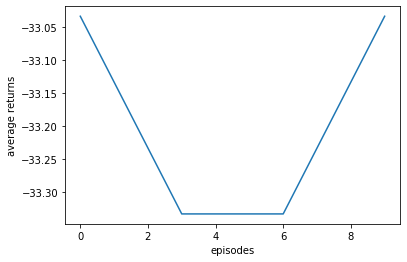

In [20]:
ppoAgent.plot_average_returns()

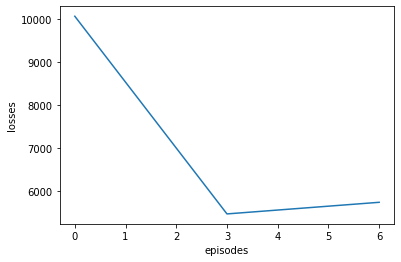

In [21]:
ppoAgent.plot_losses()

## 2. First training (with chosen policy network layers, training durations & default logging)

In [ ]:
from easyagents.tfagents import PpoAgent
from easyagents.config import TrainingDuration

In [24]:
training_duration=TrainingDuration( num_iterations = 50,
                                    num_episodes_per_iteration = 10,
                                    max_steps_per_episode = 1000,
                                    num_epochs_per_iteration = 5,
                                    num_iterations_between_eval = 10,
                                    num_eval_episodes = 10 )

In [25]:
ppoAgent = PpoAgent(    gym_env_name = 'Berater-v1',
                        fc_layers=(500,500,500), 
                        training_duration=training_duration )
ppoAgent.train()

I0624 23:23:32.575278 22948 agents.py:60] gym_env_name=Berater-v1 fc_layers=(500, 500, 500)
I0624 23:23:32.576375 22948 agents.py:69] executing: tf.compat.v1.enable_v2_behavior()
I0624 23:23:32.578297 22948 agents.py:69] executing: tf.enable_eager_execution()
I0624 23:23:32.579704 22948 agents.py:69] executing: tf.compat.v1.set_random_seed(0)
I0624 23:23:32.580279 22948 agents.py:69] Creating environment:
I0624 23:23:32.581384 22948 agents.py:69]    executing tf_py_environment.TFPyEnvironment( suite_gym.load )
I0624 23:23:32.585394 22948 agents.py:69] Creating agent:
I0624 23:23:32.586099 22948 agents.py:69]   creating  tf.compat.v1.train.AdamOptimizer( ... )
I0624 23:23:32.592112 22948 agents.py:69]   creating  PPOAgent( ... )
I0624 23:23:32.604208 22948 agents.py:69]   executing tf_agent.initialize()
I0624 23:23:32.605191 22948 agents.py:69] Creating data collection:
I0624 23:23:32.605191 22948 agents.py:69]   creating TFUniformReplayBuffer()
I0624 23:23:32.628186 22948 agents.py:69]

ppo_agent.py: creating PPOAgent(...)


I0624 23:23:34.208884 22948 logenv.py:75] #5   1.201 [R=  -3.2] game over
I0624 23:23:35.837425 22948 logenv.py:75] #5   2.201 [R=  -3.0] game over
I0624 23:23:37.374526 22948 logenv.py:75] #5   3.201 [R=  -3.3] game over
I0624 23:23:38.975446 22948 logenv.py:75] #5   4.201 [R=  -3.2] game over
I0624 23:23:40.563221 22948 logenv.py:75] #5   5.201 [R=  -3.2] game over
I0624 23:23:42.135339 22948 logenv.py:75] #5   6.201 [R=  -3.3] game over
I0624 23:23:43.604231 22948 logenv.py:75] #5   7.201 [R=  -1.7] game over
I0624 23:23:45.161143 22948 logenv.py:75] #5   8.201 [R=  -2.8] game over
I0624 23:23:46.647231 22948 logenv.py:75] #5   9.201 [R=  -3.2] game over
I0624 23:23:48.122108 22948 logenv.py:75] #5  10.201 [R=  -3.3] game over
I0624 23:23:48.125166 22948 agents.py:69] completed compute_avg_return(...) = -3.100
I0624 23:23:48.126106 22948 agents.py:69] training 1 of 50: executing collect_driver.run()
I0624 23:23:48.595163 15100 logenv.py:72] #EnvId ResetCount.Steps [R=sumRewards]
I06

ppo_agent.py: executing _train(...)
ppo_agent.py: epoch=0
ppo_agent.py: epoch=1
ppo_agent.py: epoch=2
ppo_agent.py: epoch=3
ppo_agent.py: epoch=4
ppo_agent.py: executing _train(...)
ppo_agent.py: epoch=0
ppo_agent.py: epoch=1
ppo_agent.py: epoch=2
ppo_agent.py: epoch=3
ppo_agent.py: epoch=4


I0624 23:24:01.268658 22948 agents.py:69] training 1 of 50: completed tf_agent.train(...) = 4479.675 [loss]
I0624 23:24:01.270255 22948 agents.py:69] training 1 of 50: executing replay_buffer.clear()
I0624 23:24:01.271238 22948 agents.py:69] training 2 of 50: executing collect_driver.run()
I0624 23:24:01.273164  3344 logenv.py:75] #4  11.0   [R=   0.0] executing reset(...)
I0624 23:24:01.513897  3344 logenv.py:75] #4  12.201 [R= -14.4] game over
I0624 23:24:01.729017  2520 logenv.py:75] #4  13.179 [R= -12.4] game over
I0624 23:24:01.794328 21464 logenv.py:75] #4  14.52  [R=  -3.0] game over
I0624 23:24:01.903247 10108 logenv.py:75] #4  15.90  [R=  -5.1] game over
I0624 23:24:01.984466 21464 logenv.py:75] #4  16.62  [R=  -3.2] game over
I0624 23:24:02.130287 10108 logenv.py:75] #4  17.127 [R=  -7.4] game over
I0624 23:24:02.337376 21464 logenv.py:75] #4  18.172 [R= -17.0] game over
I0624 23:24:02.495942 10108 logenv.py:75] #4  19.128 [R=  -8.1] game over
I0624 23:24:02.743566 10108 loge

ppo_agent.py: executing _train(...)
ppo_agent.py: epoch=0
ppo_agent.py: epoch=1
ppo_agent.py: epoch=2


KeyboardInterrupt: 

### Visualize

In [ ]:
ppoAgent.plot_average_returns()

In [ ]:
ppoAgent.plot_losses()

## 3. Full training (full duration, learning rate, reduced logging)

In [31]:
from easyagents.tfagents import PpoAgent
from easyagents.config import TrainingDuration
from easyagents.config import Logging

In [32]:
training_duration=TrainingDuration( num_iterations = 2000,
                                    num_episodes_per_iteration = 10,
                                    max_steps_per_episode = 1000,
                                    num_epochs_per_iteration = 5,
                                    num_iterations_between_eval = 10,
                                    num_eval_episodes = 10 )

In [34]:
logging=Logging(log_agent=True, log_gym_env=False)

In [ ]:
ppoAgent = PpoAgent(    gym_env_name = 'Berater-v1',
                        fc_layers=(500,500,500), 
                        training_duration=training_duration,
                        logging=logging,
                        learning_rate=1e-4
                   )
ppoAgent.train()

I0624 23:29:41.855004 22948 agents.py:60] gym_env_name=Berater-v1 fc_layers=(500, 500, 500)
I0624 23:29:41.856101 22948 agents.py:69] executing: tf.compat.v1.enable_v2_behavior()
I0624 23:29:41.857016 22948 agents.py:69] executing: tf.enable_eager_execution()
I0624 23:29:41.858005 22948 agents.py:69] executing: tf.compat.v1.set_random_seed(0)
I0624 23:29:41.862042 22948 agents.py:69] Creating environment:
I0624 23:29:41.863085 22948 agents.py:69]    executing tf_py_environment.TFPyEnvironment( suite_gym.load )
I0624 23:29:41.867750 22948 agents.py:69] Creating agent:
I0624 23:29:41.868785 22948 agents.py:69]   creating  tf.compat.v1.train.AdamOptimizer( ... )
I0624 23:29:41.876369 22948 agents.py:69]   creating  PPOAgent( ... )
I0624 23:29:41.888335 22948 agents.py:69]   executing tf_agent.initialize()
I0624 23:29:41.889336 22948 agents.py:69] Creating data collection:
I0624 23:29:41.889336 22948 agents.py:69]   creating TFUniformReplayBuffer()
I0624 23:29:41.910668 22948 agents.py:69]

ppo_agent.py: creating PPOAgent(...)


I0624 23:29:57.431318 22948 agents.py:69] completed compute_avg_return(...) = -3.888
I0624 23:29:57.433272 22948 agents.py:69] training 1 of 2000: executing collect_driver.run()
I0624 23:29:59.586188 22948 agents.py:69] training 1 of 2000: executing replay_buffer.gather_all()
I0624 23:29:59.591236 22948 agents.py:69] training 1 of 2000: executing tf_agent.train(...)


ppo_agent.py: executing _train(...)
ppo_agent.py: epoch=0
ppo_agent.py: epoch=1
ppo_agent.py: epoch=2
ppo_agent.py: epoch=3
ppo_agent.py: epoch=4
ppo_agent.py: executing _train(...)
ppo_agent.py: epoch=0
ppo_agent.py: epoch=1
ppo_agent.py: epoch=2
ppo_agent.py: epoch=3
ppo_agent.py: epoch=4


I0624 23:30:11.015911 22948 agents.py:69] training 1 of 2000: completed tf_agent.train(...) = 4128.440 [loss]
I0624 23:30:11.016751 22948 agents.py:69] training 1 of 2000: executing replay_buffer.clear()
I0624 23:30:11.019767 22948 agents.py:69] training 2 of 2000: executing collect_driver.run()
I0624 23:30:12.246863 22948 agents.py:69] training 2 of 2000: executing replay_buffer.gather_all()
I0624 23:30:12.249863 22948 agents.py:69] training 2 of 2000: executing tf_agent.train(...)


ppo_agent.py: executing _train(...)
ppo_agent.py: epoch=0
ppo_agent.py: epoch=1
ppo_agent.py: epoch=2
ppo_agent.py: epoch=3
ppo_agent.py: epoch=4


I0624 23:30:18.574217 22948 agents.py:69] training 2 of 2000: completed tf_agent.train(...) = 5826.175 [loss]
I0624 23:30:18.576298 22948 agents.py:69] training 2 of 2000: executing replay_buffer.clear()
I0624 23:30:18.578305 22948 agents.py:69] training 3 of 2000: executing collect_driver.run()
I0624 23:30:19.644215 22948 agents.py:69] training 3 of 2000: executing replay_buffer.gather_all()
I0624 23:30:19.650166 22948 agents.py:69] training 3 of 2000: executing tf_agent.train(...)


ppo_agent.py: executing _train(...)
ppo_agent.py: epoch=0
ppo_agent.py: epoch=1
ppo_agent.py: epoch=2
ppo_agent.py: epoch=3
ppo_agent.py: epoch=4


I0624 23:30:27.618613 22948 agents.py:69] training 3 of 2000: completed tf_agent.train(...) = 3630.698 [loss]
I0624 23:30:27.620484 22948 agents.py:69] training 3 of 2000: executing replay_buffer.clear()
I0624 23:30:27.622563 22948 agents.py:69] training 4 of 2000: executing collect_driver.run()
I0624 23:30:28.466400 22948 agents.py:69] training 4 of 2000: executing replay_buffer.gather_all()
I0624 23:30:28.470656 22948 agents.py:69] training 4 of 2000: executing tf_agent.train(...)
I0624 23:30:30.612318 22948 agents.py:69] training 4 of 2000: completed tf_agent.train(...) = 2066.112 [loss]
I0624 23:30:30.615139 22948 agents.py:69] training 4 of 2000: executing replay_buffer.clear()
I0624 23:30:30.616261 22948 agents.py:69] training 5 of 2000: executing collect_driver.run()
I0624 23:30:31.877067 22948 agents.py:69] training 5 of 2000: executing replay_buffer.gather_all()
I0624 23:30:31.880934 22948 agents.py:69] training 5 of 2000: executing tf_agent.train(...)
I0624 23:30:34.124992 22

### Visualize

In [ ]:
ppoAgent.plot_average_returns()

In [ ]:
ppoAgent.plot_losses()